# Clustering Output Analysis

Analyzing outputs from clustering run: `/mnt/polished-lake/spd/cluster/c-44665627/history.zip`

In [1]:
from pathlib import Path
from spd.clustering.merge_history import MergeHistory

# Load the history file
history_path = Path("/mnt/polished-lake/spd/cluster/c-44665627/history.zip")
history = MergeHistory.read(history_path)

# Print summary
print(history)

MergeHistory(
  c_components = 1381
  n_iters_current = 100
  total_iters = 100
  len_labels = 1381
  merge_config = {'activation_threshold': 0.1, 'alpha': 1.0, 'iters': 100, 'merge_pair_sampling_method': 'range', 'merge_pair_sampling_kwargs': {'threshold': 0.001}, 'filter_dead_threshold': 0.1, 'module_name_filter': None}
  merges_summary = {'group_idxs': 'μ=641.04 σ=397.16 x̃=640.00 R=[0,1379] shape=(100,1381) dtype=torch.int16 device=cpu ∇✗', 'k_groups': 'μ=1330.50 σ=28.87 x̃=1330.50 R=[1281,1380] shape=100 dtype=torch.int16 device=cpu ∇✗'}
)


In [2]:
# Basic clustering statistics
import torch

final_iter = history.n_iters_current - 1
final_merge = history.merges[final_iter]

print(f"=== Clustering Summary ===")
print(f"Initial components: {history.c_components}")
print(f"Iterations performed: {history.n_iters_current}")
print(f"Initial clusters (iter 0): {history.initial_k_groups}")
print(f"Final clusters (iter {final_iter}): {history.final_k_groups}")
print(f"Clusters merged: {history.initial_k_groups - history.final_k_groups}")

=== Clustering Summary ===
Initial components: 1381
Iterations performed: 100
Initial clusters (iter 0): 1380
Final clusters (iter 99): 1281
Clusters merged: 99


In [3]:
# Analyze cluster sizes at final iteration
cluster_sizes = final_merge.components_per_group

print(f"=== Cluster Size Distribution (Final Iteration) ===")
print(f"Number of clusters: {len(cluster_sizes)}")
print(f"Total components assigned: {cluster_sizes.sum().item()}")
print(f"Min cluster size: {cluster_sizes.min().item()}")
print(f"Max cluster size: {cluster_sizes.max().item()}")
print(f"Mean cluster size: {cluster_sizes.float().mean().item():.2f}")
print(f"Median cluster size: {cluster_sizes.float().median().item():.1f}")

# Distribution of sizes
size_counts = {}
for size in cluster_sizes.tolist():
    size_counts[size] = size_counts.get(size, 0) + 1

print(f"\n=== Size Distribution ===")
for size in sorted(size_counts.keys()):
    count = size_counts[size]
    print(f"  Size {size}: {count} clusters ({100*count/len(cluster_sizes):.1f}%)")

=== Cluster Size Distribution (Final Iteration) ===
Number of clusters: 1281
Total components assigned: 1381
Min cluster size: 1
Max cluster size: 101
Mean cluster size: 1.08
Median cluster size: 1.0

=== Size Distribution ===
  Size 1: 1280 clusters (99.9%)
  Size 101: 1 clusters (0.1%)


In [4]:
# Find the large cluster and analyze its contents
large_cluster_idx = cluster_sizes.argmax().item()
large_cluster_id = final_merge.group_idxs.unique()[large_cluster_idx]

# Get components in the large cluster
large_cluster_components = final_merge.components_in_group(large_cluster_id)
large_cluster_labels = history.get_cluster_component_labels(iteration=-1, cluster_id=large_cluster_id)

print(f"=== Large Cluster Analysis (ID: {large_cluster_id}) ===")
print(f"Number of components: {len(large_cluster_labels)}")
print(f"\nComponent labels in large cluster:")
for label in large_cluster_labels[:20]:  # Show first 20
    print(f"  {label}")
if len(large_cluster_labels) > 20:
    print(f"  ... and {len(large_cluster_labels) - 20} more")

=== Large Cluster Analysis (ID: 8) ===
Number of components: 101

Component labels in large cluster:
  h.0.attn.q_proj:125
  h.0.attn.q_proj:363
  h.0.attn.k_proj:223
  h.0.attn.k_proj:442
  h.0.attn.k_proj:561
  h.0.attn.o_proj:1
  h.0.attn.o_proj:15
  h.0.attn.o_proj:26
  h.0.attn.o_proj:61
  h.0.attn.o_proj:101
  h.0.attn.o_proj:114
  h.0.attn.o_proj:146
  h.0.attn.o_proj:175
  h.0.attn.o_proj:219
  h.0.attn.o_proj:224
  h.0.attn.o_proj:233
  h.0.attn.o_proj:320
  h.0.attn.o_proj:321
  h.0.attn.o_proj:370
  h.0.attn.o_proj:444
  ... and 81 more


In [5]:
# Layer-by-layer breakdown of all components
from collections import defaultdict

# Parse all labels to understand module structure
module_components = defaultdict(list)
for label in history.labels:
    module, idx = label.rsplit(":", 1)
    module_components[module].append(int(idx))

print(f"=== Module Breakdown ===")
print(f"Total modules: {len(module_components)}")
print()
for module in sorted(module_components.keys()):
    components = module_components[module]
    print(f"{module}: {len(components)} components (indices {min(components)}-{max(components)})")

=== Module Breakdown ===
Total modules: 6

h.0.attn.k_proj: 69 components (indices 0-649)
h.0.attn.o_proj: 168 components (indices 1-649)
h.0.attn.q_proj: 53 components (indices 1-629)
h.0.attn.v_proj: 143 components (indices 3-648)
h.0.mlp.c_fc: 506 components (indices 1-649)
h.0.mlp.down_proj: 442 components (indices 1-648)


In [6]:
# Analyze the large cluster's module composition
large_cluster_module_counts = defaultdict(int)
for label in large_cluster_labels:
    module, _ = label.rsplit(":", 1)
    large_cluster_module_counts[module] += 1

print("=== Large Cluster Module Composition ===")
for module in sorted(large_cluster_module_counts.keys()):
    count = large_cluster_module_counts[module]
    total_in_module = len(module_components[module])
    print(f"{module}: {count}/{total_in_module} ({100*count/total_in_module:.1f}%)")

=== Large Cluster Module Composition ===
h.0.attn.k_proj: 3/69 (4.3%)
h.0.attn.o_proj: 26/168 (15.5%)
h.0.attn.q_proj: 2/53 (3.8%)
h.0.mlp.c_fc: 33/506 (6.5%)
h.0.mlp.down_proj: 37/442 (8.4%)


In [7]:
# Comprehensive layer-by-layer cluster membership analysis
import numpy as np

# Build a mapping: component_label -> cluster_id at final iteration
label_to_cluster = {}
group_idxs = final_merge.group_idxs.numpy()
for comp_idx, label in enumerate(history.labels):
    label_to_cluster[label] = group_idxs[comp_idx]

# Analyze each module
print("=== Layer-by-Layer Cluster Membership ===\n")

for module in sorted(module_components.keys()):
    component_indices = module_components[module]
    
    # Get cluster assignments for this module's components
    cluster_ids = []
    for idx in component_indices:
        label = f"{module}:{idx}"
        if label in label_to_cluster:
            cluster_ids.append(label_to_cluster[label])
    
    unique_clusters = set(cluster_ids)
    
    # Count how many components per cluster
    cluster_counts = defaultdict(int)
    for cid in cluster_ids:
        cluster_counts[cid] += 1
    
    # Find clusters with >1 component from this module
    multi_component_clusters = {cid: cnt for cid, cnt in cluster_counts.items() if cnt > 1}
    
    print(f"### {module} ###")
    print(f"  Components: {len(cluster_ids)}")
    print(f"  Unique clusters: {len(unique_clusters)}")
    print(f"  Singletons (own cluster): {sum(1 for cnt in cluster_counts.values() if cnt == 1)}")
    
    if multi_component_clusters:
        print(f"  Multi-component clusters from this module:")
        for cid, cnt in sorted(multi_component_clusters.items(), key=lambda x: -x[1]):
            print(f"    Cluster {cid}: {cnt} components")
    
    # Check if any components are in the large cluster
    in_large_cluster = sum(1 for cid in cluster_ids if cid == large_cluster_id)
    if in_large_cluster > 0:
        print(f"  → In large cluster (ID {large_cluster_id}): {in_large_cluster}")
    print()

=== Layer-by-Layer Cluster Membership ===

### h.0.attn.k_proj ###
  Components: 69
  Unique clusters: 67
  Singletons (own cluster): 66
  Multi-component clusters from this module:
    Cluster 8: 3 components
  → In large cluster (ID 8): 3

### h.0.attn.o_proj ###
  Components: 168
  Unique clusters: 143
  Singletons (own cluster): 142
  Multi-component clusters from this module:
    Cluster 8: 26 components
  → In large cluster (ID 8): 26

### h.0.attn.q_proj ###
  Components: 53
  Unique clusters: 52
  Singletons (own cluster): 51
  Multi-component clusters from this module:
    Cluster 8: 2 components
  → In large cluster (ID 8): 2

### h.0.attn.v_proj ###
  Components: 143
  Unique clusters: 143
  Singletons (own cluster): 143

### h.0.mlp.c_fc ###
  Components: 506
  Unique clusters: 474
  Singletons (own cluster): 473
  Multi-component clusters from this module:
    Cluster 8: 33 components
  → In large cluster (ID 8): 33

### h.0.mlp.down_proj ###
  Components: 442
  Unique clu

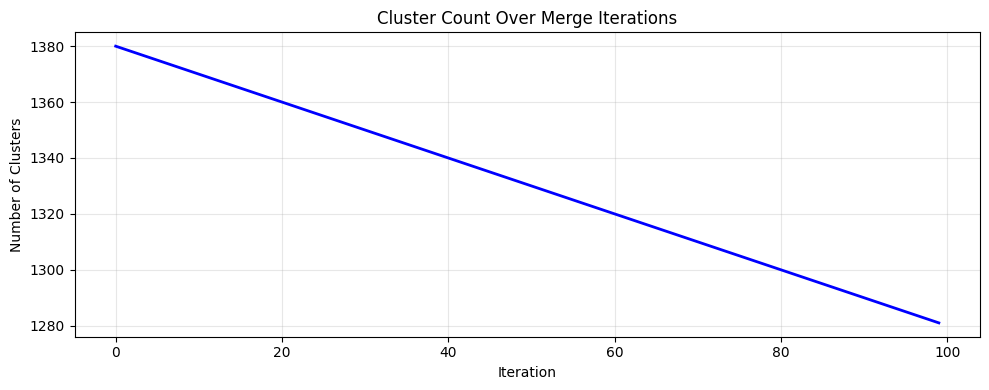

In [8]:
# Visualize cluster count over iterations
import matplotlib.pyplot as plt

k_groups_over_time = history.merges.k_groups.numpy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(k_groups_over_time)), k_groups_over_time, 'b-', linewidth=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Number of Clusters")
ax.set_title("Cluster Count Over Merge Iterations")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

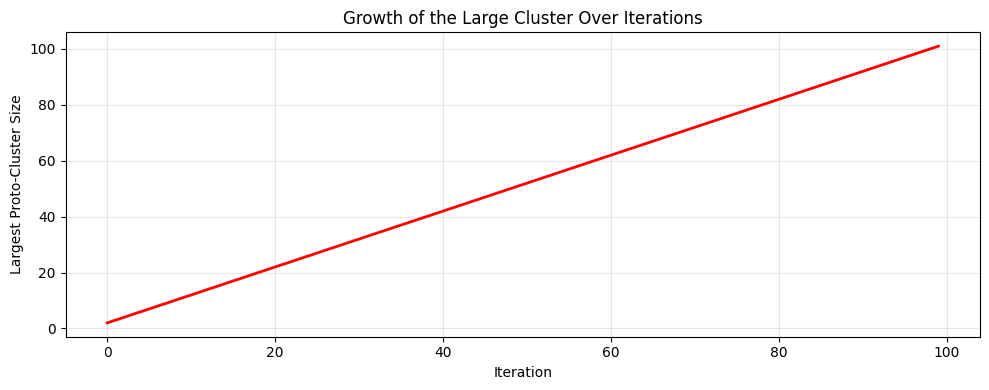

Large cluster started growing around iteration: 0
Final size: 101


In [9]:
# Track the large cluster's growth over iterations
# Find which cluster ID the large cluster had at each iteration
# (cluster IDs can change as merges happen)

# We'll track by following the components that end up in the large cluster
final_large_cluster_components = set(final_merge.components_in_group(large_cluster_id))

cluster_size_over_time = []
for iter_idx in range(history.n_iters_current):
    merge = history.merges[iter_idx]
    group_idxs = merge.group_idxs.numpy()
    
    # Find what clusters contain our target components at this iteration
    cluster_ids_for_target = set(group_idxs[list(final_large_cluster_components)])
    
    # The largest group containing any of our target components
    max_size = 0
    for cid in cluster_ids_for_target:
        size = (group_idxs == cid).sum()
        max_size = max(max_size, size)
    
    cluster_size_over_time.append(max_size)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(cluster_size_over_time)), cluster_size_over_time, 'r-', linewidth=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Largest Proto-Cluster Size")
ax.set_title("Growth of the Large Cluster Over Iterations")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Large cluster started growing around iteration: {next(i for i, s in enumerate(cluster_size_over_time) if s > 1)}")
print(f"Final size: {cluster_size_over_time[-1]}")

In [10]:
# Create a summary DataFrame for easier viewing
import pandas as pd

# Summary statistics
summary_data = []
for module in sorted(module_components.keys()):
    component_indices = module_components[module]
    
    cluster_ids = []
    for idx in component_indices:
        label = f"{module}:{idx}"
        if label in label_to_cluster:
            cluster_ids.append(label_to_cluster[label])
    
    unique_clusters = len(set(cluster_ids))
    in_large = sum(1 for cid in cluster_ids if cid == large_cluster_id)
    singletons = len(cluster_ids) - in_large  # approximate, since all non-large are singletons here
    
    summary_data.append({
        "Module": module.replace("h.0.", ""),
        "Components": len(cluster_ids),
        "Unique Clusters": unique_clusters,
        "In Large Cluster": in_large,
        "Singletons": len(cluster_ids) - in_large,
        "% in Large": f"{100*in_large/len(cluster_ids):.1f}%"
    })

df = pd.DataFrame(summary_data)
print("=== Summary Table ===\n")
print(df.to_string(index=False))

print(f"\n=== Key Findings ===")
print(f"• Total components: {history.c_components}")
print(f"• Final clusters: {history.final_k_groups}")
print(f"• One dominant cluster (ID {large_cluster_id}) absorbed 101 components across 5/6 modules")
print(f"• v_proj is the ONLY module with no components in the large cluster")
print(f"• All other components remain as singletons")

=== Summary Table ===

       Module  Components  Unique Clusters  In Large Cluster  Singletons % in Large
  attn.k_proj          69               67                 3          66       4.3%
  attn.o_proj         168              143                26         142      15.5%
  attn.q_proj          53               52                 2          51       3.8%
  attn.v_proj         143              143                 0         143       0.0%
     mlp.c_fc         506              474                33         473       6.5%
mlp.down_proj         442              406                37         405       8.4%

=== Key Findings ===
• Total components: 1381
• Final clusters: 1281
• One dominant cluster (ID 8) absorbed 101 components across 5/6 modules
• v_proj is the ONLY module with no components in the large cluster
• All other components remain as singletons


In [11]:
# Examine the first few merges to understand what's being merged
print("=== First 15 Merge Pairs ===\n")
for i in range(min(15, history.n_iters_current)):
    pair = history.selected_pairs[i]
    comp_a, comp_b = pair[0], pair[1]
    label_a = history.labels[comp_a] if comp_a < len(history.labels) else f"?{comp_a}"
    label_b = history.labels[comp_b] if comp_b < len(history.labels) else f"?{comp_b}"
    print(f"Iter {i:3d}: ({comp_a:4d}, {comp_b:4d}) → {label_a} + {label_b}")

=== First 15 Merge Pairs ===

Iter   0: ( 944,  659) → h.0.mlp.down_proj:6 + h.0.mlp.c_fc:291
Iter   1: (   8,  659) → h.0.attn.q_proj:125 + h.0.mlp.c_fc:291
Iter   2: (  83,    8) → h.0.attn.k_proj:223 + h.0.attn.q_proj:125
Iter   3: ( 381,    8) → h.0.attn.o_proj:466 + h.0.attn.q_proj:125
Iter   4: (   8,  384) → h.0.attn.q_proj:125 + h.0.attn.o_proj:473
Iter   5: ( 609,    8) → h.0.mlp.c_fc:225 + h.0.attn.q_proj:125
Iter   6: ( 927,    8) → h.0.mlp.c_fc:633 + h.0.attn.q_proj:125
Iter   7: (   8,  738) → h.0.attn.q_proj:125 + h.0.mlp.c_fc:392
Iter   8: (   8,  607) → h.0.attn.q_proj:125 + h.0.mlp.c_fc:223
Iter   9: (   8,  103) → h.0.attn.q_proj:125 + h.0.attn.k_proj:437
Iter  10: (   8, 1078) → h.0.attn.q_proj:125 + h.0.mlp.down_proj:195
Iter  11: ( 739,    8) → h.0.mlp.c_fc:394 + h.0.attn.q_proj:125
Iter  12: ( 325,    8) → h.0.attn.o_proj:227 + h.0.attn.q_proj:125
Iter  13: ( 297,    8) → h.0.attn.o_proj:142 + h.0.attn.q_proj:125
Iter  14: ( 793,    8) → h.0.mlp.c_fc:465 + h.0.att

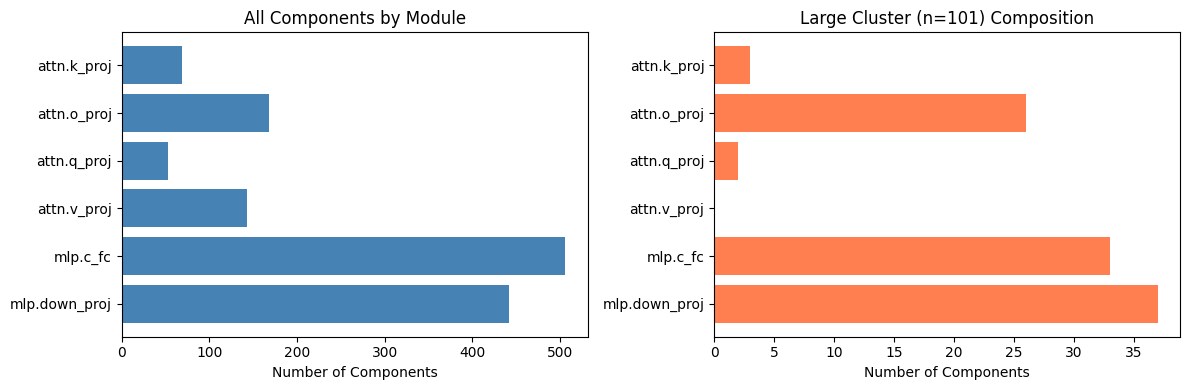

In [12]:
# Visualize module composition in the large cluster vs overall
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overall module distribution
modules = [m.replace("h.0.", "") for m in sorted(module_components.keys())]
total_counts = [len(module_components[f"h.0.{m}"]) for m in modules]

axes[0].barh(modules, total_counts, color='steelblue')
axes[0].set_xlabel("Number of Components")
axes[0].set_title("All Components by Module")
axes[0].invert_yaxis()

# Large cluster composition
large_counts = [large_cluster_module_counts.get(f"h.0.{m}", 0) for m in modules]
colors = ['coral' if c > 0 else 'lightgray' for c in large_counts]
axes[1].barh(modules, large_counts, color=colors)
axes[1].set_xlabel("Number of Components")
axes[1].set_title(f"Large Cluster (n={sum(large_counts)}) Composition")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [13]:
# Full breakdown of large cluster components by module
print("=== Large Cluster Components by Module ===\n")

large_cluster_by_module = defaultdict(list)
for label in large_cluster_labels:
    module, idx = label.rsplit(":", 1)
    large_cluster_by_module[module].append(int(idx))

for module in sorted(large_cluster_by_module.keys()):
    indices = sorted(large_cluster_by_module[module])
    short_module = module.replace("h.0.", "")
    print(f"{short_module} ({len(indices)} components):")
    print(f"  Indices: {indices}")
    print()

=== Large Cluster Components by Module ===

attn.k_proj (3 components):
  Indices: [223, 442, 561]

attn.o_proj (26 components):
  Indices: [1, 15, 26, 61, 101, 114, 146, 175, 219, 224, 233, 320, 321, 370, 444, 452, 462, 471, 477, 516, 532, 546, 576, 593, 597, 649]

attn.q_proj (2 components):
  Indices: [125, 363]

mlp.c_fc (33 components):
  Indices: [2, 35, 109, 160, 188, 201, 211, 227, 230, 232, 240, 251, 289, 291, 294, 304, 324, 342, 346, 399, 405, 416, 445, 480, 483, 498, 499, 533, 546, 575, 607, 635, 640]

mlp.down_proj (37 components):
  Indices: [6, 17, 54, 63, 73, 93, 103, 115, 128, 134, 140, 155, 163, 184, 210, 219, 241, 244, 247, 251, 297, 324, 339, 354, 384, 401, 437, 465, 467, 472, 495, 505, 512, 513, 549, 570, 643]



## Summary

**Clustering Run:** `/mnt/polished-lake/spd/cluster/c-44665627/history.zip`

### Key Statistics
| Metric | Value |
|--------|-------|
| Initial components | 1381 |
| Iterations | 100 |
| Final clusters | 1281 |

### Findings

1. **One dominant "sink" cluster** (ID 8) absorbed 101 components across iterations
2. **Linear growth**: The large cluster grew by ~1 component per iteration, suggesting a greedy merge pattern
3. **Module exclusion**: `v_proj` is the ONLY module with zero components in the large cluster
4. **All other components remain singletons** - no other multi-component clusters formed

### Module Breakdown

| Module | Total | In Large Cluster | % |
|--------|-------|------------------|---|
| attn.k_proj | 69 | 3 | 4.3% |
| attn.o_proj | 168 | 26 | 15.5% |
| attn.q_proj | 53 | 2 | 3.8% |
| attn.v_proj | 143 | **0** | 0.0% |
| mlp.c_fc | 506 | 33 | 6.5% |
| mlp.down_proj | 442 | 37 | 8.4% |

### Interpretation
The large cluster likely represents low-activation or "background" components that coactivate weakly together. The fact that `v_proj` has no members suggests its components have more distinct activation patterns.